In [1]:
%matplotlib inline

from datetime import datetime as dt
import pickle

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 150)

In [2]:
bo_open_df = pd.read_csv('./bo_open_ts.csv')
bo_open_df = bo_open_df.loc[
    bo_open_df.year >= 2013
]
bo_open_df.dropna(inplace=True)
bo_open_df.drop('week', axis=1, inplace=True)

In [3]:
sums_df = bo_open_df.groupby(['year', 'month'], as_index=False).sum()
sums_df = sums_df.groupby('month').mean()

sums_df.drop('year', axis=1, inplace=True)

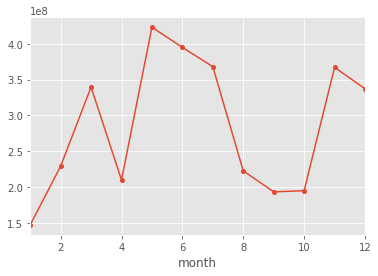

In [4]:
sums_df.opening_weekend_gross.plot(marker='o', markersize=4)

#### Look at regression residuals.

In [5]:
nrg_bom_df = pd.read_csv('./nrg_bom_df.p')

nrg_bom_df['def/pos'] = nrg_bom_df.definite_int / nrg_bom_df.positive_int
nrg_bom_df['def/pos_sq'] = nrg_bom_df['def/pos'] * nrg_bom_df['def/pos']

predictor_columns = [
    'unaided_intent',
    'first_choice',
    'def/pos',
    'def/pos_sq'
]
target_column = 'opening_weekend_gross'

X = nrg_bom_df.loc[:, predictor_columns].values
y = nrg_bom_df.loc[:, target_column].values

In [6]:
lr = pickle.load(open('./lr.p', 'rb'))

df = nrg_bom_df.copy()
df['lr_prediction'] = lr.predict(X)
df['residual'] = df.opening_weekend_gross - df.lr_prediction

def get_year_month_week(date_str):
    date = dt.strptime(date_str, '%Y-%m-%d')
    year = date.year
    month = date.month
    week = date.date().isocalendar()[1]
    return year, month, week

df[['year', 'month', 'week']] = pd.DataFrame(
    list(map(get_year_month_week, df.release_date))
)

In [25]:
residuals_df = df.loc[:, ['month', 'residual']].groupby('month', as_index=False).mean()
residuals_df = residuals_df.merge(sums_df.reset_index())

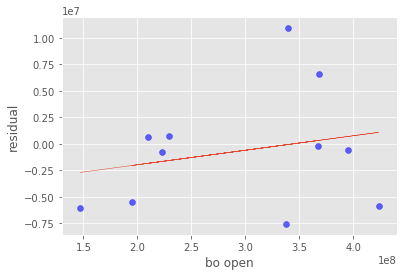

In [27]:
X = residuals_df.opening_weekend_gross.values.reshape(-1, 1)
y = residuals_df.residual.values

lr = LinearRegression()
lr.fit(X, y)

predictions = lr.predict(X)

x = X.reshape(X.shape[0])

ax = plt.plot(x, predictions, linewidth=.5)[0]
plt.scatter(x, y, color='b', alpha=.6)
ax.axes.set_xlabel('bo open')
ax.axes.set_ylabel('residual')

In [29]:
residuals_df.loc[
    (residuals_df.opening_weekend_gross >= 300000000) &
    (residuals_df.opening_weekend_gross <= 500000000)
].sort_values('residual')

,month,residual,opening_weekend_gross
10,12,-7.593944e+06,3.372634e+08
4,5,-5.844608e+06,4.232569e+08
5,6,-5.459315e+05,3.950757e+08
9,11,-1.908941e+05,3.671643e+08
6,7,6.636077e+06,3.681560e+08
2,3,1.095858e+07,3.396466e+08


#### Remove peak months.

Remove peak movie months 5, 6, 7, 11, 12, as they appear to behave differently than the other months.

In [35]:
peak_months = [5, 6, 7, 11, 12]

non_peak_df = residuals_df.loc[
    ~residuals_df.month.isin(peak_months)
]

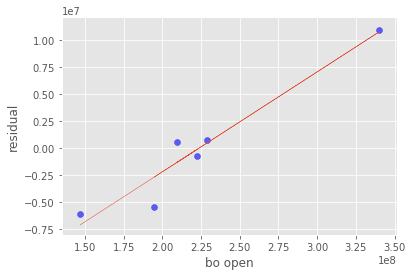

In [37]:
X = non_peak_df.opening_weekend_gross.values.reshape(-1, 1)
y = non_peak_df.residual.values

lr = LinearRegression()
lr.fit(X, y)

predictions = lr.predict(X)

x = X.reshape(X.shape[0])

ax = plt.plot(x, predictions, linewidth=.5)[0]
plt.scatter(x, y, color='b', alpha=.6)
ax.axes.set_xlabel('bo open')
ax.axes.set_ylabel('residual')